# Import Libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from uo2009.dgp.params import EfficientPriceParams, NoiseParamsMA2
from uo2009.dgp.simulate import simulate_section4_1_1

from uo2009.estimators.statistics_cross_noise_dep import (
    build_Z_sequence,
    compute_tau_from_Z,
    subsampling_variance_nonoverlapping,
    select_threshold_via_tau,
    compute_tau
)

# Helpers

In [100]:
def cross_covariance(x: np.ndarray, y: np.ndarray, max_lag: int):
    """
    Sample cross-covariance gamma_xy(h) = Cov(x_t, y_{t-h})
    for h in [-max_lag, ..., max_lag], using mean-centered series.

    Note:
      h > 0  -> x leads y (x_t with y_{t-h})
      h < 0  -> y leads x (x_t with y_{t+|h|})
    """
    x0 = x - x.mean()
    y0 = y - y.mean()
    n = x0.size

    lags = np.arange(-max_lag, max_lag + 1, dtype=int)
    ccov = np.empty_like(lags, dtype=float)

    for idx, h in enumerate(lags):
        if h >= 0:
            ccov[idx] = np.dot(x0[h:], y0[: n - h]) / n
        else:
            hp = -h
            ccov[idx] = np.dot(x0[: n - hp], y0[hp:]) / n

    return lags, ccov

## Create parameter objects

In [2]:
eff_params = EfficientPriceParams()     # uses defaults in params.py
noise_params = NoiseParamsMA2()         # nsr1, nsr2

## One simulation run + returns

In [80]:
rng = np.random.default_rng(123)

out = simulate_section4_1_1(
    eff_params=eff_params,
    noise_params=noise_params,
    delta_seconds=10.0, # sampling every 10 seconds
    rng=rng,
)

y = out.y_obs           # (n_obs, 2)
t_obs = out.t_obs       # (n_obs, 1)

# Observed prices of the two assets
y1_obs = y[:, 0]
y2_obs = y[:, 1]

In [81]:
df = pd.DataFrame({
    't_obs': t_obs,
    'y1_obs': y1_obs,
    'y2_obs': y2_obs,
})

df.head()

,t_obs,y1_obs,y2_obs
0,0.0,-9.840741,-10.063818
1,10.0,13.585917,9.165026
2,20.0,8.447977,-18.628092
3,30.0,8.839430,-7.634045
4,40.0,-0.147256,-2.916591


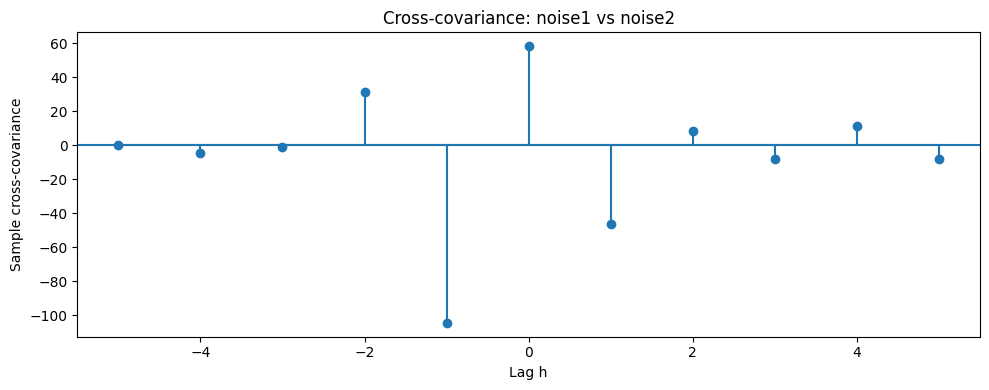

In [101]:
noise1 = out.noise[:,0]
noise2 = out.noise[:,1]

L = 5
lags, ccov = cross_covariance(noise1, noise2, max_lag=L)

plt.figure(figsize=(10, 4))
plt.stem(lags, ccov)
plt.axhline(0)
plt.xlabel("Lag h")
plt.ylabel("Sample cross-covariance")
plt.title("Cross-covariance: noise1 vs noise2")
plt.tight_layout()
plt.show()

### $\ell = 1$
First, construct a series {Z_1}

In [82]:
Z_1 = build_Z_sequence(
    t1=list(range(t_obs.size)),
    y1=y1_obs,
    t2=list(range(t_obs.size)),
    y2=y2_obs,
    ell=1,
    ell_in="ticks")  

In [83]:
print(Z_1[:3])

print(f"There are {Z_1.size} elements in Z_1")

print(f"The first element of Z_1 should be\
      {(y1_obs[3]-y1_obs[2]) * (y2_obs[1]-y2_obs[0])\
       }")

[  7.52720507 249.76804429 261.63201755]
There are 2338 elements in Z_1
The first element of Z_1 should be      7.5272050706700036


Now, construct a variance estimator

In [84]:
sigmasq_1 = subsampling_variance_nonoverlapping(
    Z=Z_1,
    c=1,
)

In [85]:
sigmasq_1

(679882.929671137, 13, 179)

Compute $\tau$

In [86]:
tau_1 = (np.sqrt(Z_1.size) * np.mean(Z_1)) / np.sqrt(sigmasq_1[0])

In [87]:
tau_1

np.float64(3.9029962680255976)

In [88]:
# Use compute_tau_from_Z function
tau_1_check = compute_tau_from_Z(
    Z=Z_1,
    c=1,
    ell=1,
)

In [89]:
tau_1_check.tau

3.9029962680255976

In [90]:
tau_1_check_2 = compute_tau(
    t1=list(range(t_obs.size)),
    y1=y1_obs,
    t2=list(range(t_obs.size)),
    y2=y2_obs,
    ell=1,
    ell_in="ticks",
    c=1,
)
tau_1_check_2.tau

3.9029962680255976

### $\ell = 2$

Construct Z_2

In [91]:
# Construct Z_2 for ell=2
Z_2 = build_Z_sequence(
    t1=list(range(t_obs.size)),
    y1=y1_obs,
    t2=list(range(t_obs.size)),
    y2=y2_obs,
    ell=2,
    ell_in="ticks")

In [92]:
Z_2[:3]

array([-172.80359683, -661.40972063,   83.52698992])

In [93]:
df.head()

,t_obs,y1_obs,y2_obs
0,0.0,-9.840741,-10.063818
1,10.0,13.585917,9.165026
2,20.0,8.447977,-18.628092
3,30.0,8.839430,-7.634045
4,40.0,-0.147256,-2.916591


In [94]:
print(Z_2[:3])
print(f'There are {Z_2.size} elements in Z_2')
print(f'first element should be: {(y1_obs[4]-y1_obs[3]) * (y2_obs[1]-y2_obs[0])}')
print(f'second element should be: {(y1_obs[5]-y1_obs[4]) * (y2_obs[2]-y2_obs[1])}')

[-172.80359683 -661.40972063   83.52698992]
There are 2337 elements in Z_2
first element should be: -172.8035968299688
second element should be: -661.4097206345197


In [95]:
sigmasq_2= subsampling_variance_nonoverlapping(
    Z=Z_2,
    c=1,
)

sigmasq_2

(654012.8328933063, 13, 179)

In [96]:
tau_2 = (np.sqrt(Z_2.size) * np.mean(Z_2)) / np.sqrt(sigmasq_2[0])
tau_2

np.float64(-1.8737140339866234)

In [97]:
tau_2_check = compute_tau_from_Z(
    Z=Z_2,
    c=1,
    ell=2,
)
tau_2_check.tau

-1.8737140339866234

### Threshold selection

In [53]:
res = select_threshold_via_tau(
            t1=list(range(t_obs.size)),
            y1=y1_obs,
            t2=list(range(t_obs.size)),
            y2=y2_obs,
            ells_descending=[5,4,3,2,1],
            ell_in="ticks",
            c = 1,
        )

In [54]:
res

ThresholdResult(ell_star=4, cv=1.96, direction='descending_from_L', tested=(TauResult(ell=5, N_ell=2334, Zbar=22.559009689235673, sigma2_hat=573836.1576619506, sigma_hat=757.5197407737639, tau=1.4387207315338961, M=13, K=179), TauResult(ell=4, N_ell=2335, Zbar=-35.493707816193165, sigma2_hat=593141.2729373513, sigma_hat=770.1566548030025, tau=-2.2269770419364496, M=13, K=179)))

# Replication: Table 1

In [112]:
# ======================================================
# Set up
# ======================================================
c_grid = np.array([4.0, 2.0, 1.0, 0.5], dtype=float)
dt_grid = np.array([5, 10, 15, 30], dtype=int)
L = 50
ells_descending = list(range(L, -1, -1)) 
cv = 1.96
R = 100 # number of Monte Carlo replications
rng = np.random.default_rng(12345) # For reproducibility


In [113]:
import os
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# choose number of workers ("drivers")
# - set workers = -1 to use all cores
workers = 4

# Store results: Prob(m^+ < 2) for each (c, dt)
out = pd.DataFrame(
    index=[f"c = {c:g}" for c in c_grid],
    columns=[f"{dt} sec" for dt in dt_grid],
    dtype=float,
)

# Make runs reproducible across parallel workers
# (spawn independent child RNGs deterministically)
master_seed = 12345
master_rng = np.random.default_rng(master_seed)

# Create a distinct seed for every (c, dt, r)
all_seeds = master_rng.integers(0, 2**32 - 1, size=(len(c_grid), len(dt_grid), R), dtype=np.uint32)

for ci, c in enumerate(c_grid):
    for dti, dt in enumerate(dt_grid):

        seeds = all_seeds[ci, dti, :]

        def _one_rep(seed: int):
            rng_local = np.random.default_rng(int(seed))

            sim_data = simulate_section4_1_1(
                eff_params=eff_params,
                noise_params=noise_params,
                delta_seconds=dt,
                rng=rng_local,
            )
            y = sim_data.y_obs
            t_obs = sim_data.t_obs

            y1_obs = y[:, 0]
            y2_obs = y[:, 1]

            # ticks index (must be integer-like for ell_in="ticks")
            t1 = np.arange(t_obs.size, dtype=int)
            t2 = np.arange(t_obs.size, dtype=int)

            res = select_threshold_via_tau(
                t1, y1_obs, t2, y2_obs,
                ells_descending=ells_descending,
                ell_in="ticks",
                cv=cv,
                c=c,
                M=None,
            )

            m_plus_hat = res.ell_star
            return int(m_plus_hat < 2), m_plus_hat

        results = Parallel(n_jobs=workers, backend="loky")(
            delayed(_one_rep)(int(s)) for s in seeds
        )

        hits = np.array([h for h, _ in results], dtype=int)
        mplus = [m for _, m in results]

        # optional: print per-rep results (kept similar to your original)
        for r, m in enumerate(mplus):
            print(f"Replication {r+1}, c={c}, dt={dt}: m^+_hat = {m}")

        out.iloc[ci, dti] = hits.mean()

out

Replication 1, c=4.0, dt=5: m^+_hat = 1
Replication 2, c=4.0, dt=5: m^+_hat = 45
Replication 3, c=4.0, dt=5: m^+_hat = 50
Replication 4, c=4.0, dt=5: m^+_hat = 40
Replication 5, c=4.0, dt=5: m^+_hat = 1
Replication 6, c=4.0, dt=5: m^+_hat = 1
Replication 7, c=4.0, dt=5: m^+_hat = 1
Replication 8, c=4.0, dt=5: m^+_hat = 15
Replication 9, c=4.0, dt=5: m^+_hat = 49
Replication 10, c=4.0, dt=5: m^+_hat = 46
Replication 11, c=4.0, dt=5: m^+_hat = 6
Replication 12, c=4.0, dt=5: m^+_hat = 3
Replication 13, c=4.0, dt=5: m^+_hat = 41
Replication 14, c=4.0, dt=5: m^+_hat = 6
Replication 15, c=4.0, dt=5: m^+_hat = 26
Replication 16, c=4.0, dt=5: m^+_hat = 40
Replication 17, c=4.0, dt=5: m^+_hat = 17
Replication 18, c=4.0, dt=5: m^+_hat = 9
Replication 19, c=4.0, dt=5: m^+_hat = 2
Replication 20, c=4.0, dt=5: m^+_hat = 34
Replication 21, c=4.0, dt=5: m^+_hat = 49
Replication 22, c=4.0, dt=5: m^+_hat = 1
Replication 23, c=4.0, dt=5: m^+_hat = 37
Replication 24, c=4.0, dt=5: m^+_hat = 21
Replication

,5 sec,10 sec,15 sec,30 sec
c = 4,0.14,0.20,0.17,0.12
c = 2,0.23,0.28,0.21,0.18
c = 1,0.16,0.22,0.28,0.15
c = 0.5,0.16,0.27,0.19,0.17
